# Report

---

### Introduction

That project explores the use of the [classic DQN reinforcement learning (Mnih, 2015)](https://files.davidqiu.com//research/nature14236.pdf) algorithm to solve a Unity game. The goal is for the agent to navigate a 3D environment to collect yellow bananas (reward +1) while avoiding black bananas (reward -1). We consider the game solved when an average score of 13 is reached over 100 playing episodes.

The DQN algorithms built on the idea of Q-learning, which uses the Temporal Difference method to approximate tha action-value function Q. Actions are taken by a greedy policy that maximize the action-value. The epsilon-greedy policy is used to ensure sufficient exploration of the state-action space in the initial stages of training.

(Mnih, 2015) implementation of the DQN algorithms uses a neural network as a function approximator, which let the agent learn in large, continuous spaces, without a need for discretization. In order to train the neural network efficiently, (Mnih, 2015) makes uses of the technique of experience replay, which let the agent learn from past episodes and breaks the time dependency between episodes, as well as the technique of using two identical networks, called local and target, for learning and for action-value estimation. Both networked are synchronized every few steps during the soft update process.

We'll also compare the performance of the classic DQN with several variations of the algorithm:

- [Double DQN (DDQN) (Hasselt, 2015)](https://arxiv.org/abs/1509.06461) DDQN introduce a clever modification in how the action-value are estimated, by using both the local network to select the action and using the target network to estimate it's value. The modification is supposed to stabilize the learning.
- [Prioritized Experience Replay DDQN (PER-DDQN) (Schaul, 2015)](https://arxiv.org/abs/1511.05952) PER changed the way the past experiences are replayed, by putting a higher sampling weight on experiences with a higher TD error (more "unexpected" experiences). The change is supposed to lead to higher learning efficiency.
- [Dueling Networks DDQN (also using Prioritized Experience Replay) (Dueling-DDQN) (Wang, 2015)](https://arxiv.org/abs/1511.06581) Dueling networks split the action-value function into two sub-functions: value and action advantage, which are then compared to find the action-value. Both functions and the comparison are implemented with a single neural network, so the gradient updates are done end-to-end in one pass. 

### 0. Algorithms

For comparison purposes, all the algorithms use the same neural network:

- Takes state variable as input
- 2x hidden layers of size 64
- 1 output layer of the size of the action space
- ReLu activation functions

For the dueling networks architecture, the value and action advantage network share the first hidden layer but have separate second layer and output layers. The action advantage layer is normalized by the mean as in (Wang, 2015)  

#### Hyper parameters

Replay buffer size:
BUFFER_SIZE = int(1e5)  
Minibatch size:
BATCH_SIZE = 64        
Discount factor:
GAMMA = 0.99            
Soft update of target parameter:
TAU = 1e-3              
Learning rate for Adam optimizer:
LR = 5e-4               
How often to update the target network with local network weights
UPDATE_EVERY = 4        
Number of training episodes:
n_episodes=2000
Maximum duration of episode:
max_t=1000
Epsilon for eplison greedy policy:
eps_start=1.0
eps_end=0.01
eps_decay=0.995

For prioritized experience replay:
ALPHA = 0.5  
BETA = 0.1, updated to BETA = BETA**(1-BETA) at each training iteration (converges to BETA = 1)

### 1. Unity Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip -q install ./python

jupyter-console 6.2.0 has requirement prompt-toolkit!=3.0.0,!=3.0.1,<3.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.15 which is incompatible.


Load the Unity environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. State and Action Spaces

Run the code cell below to print some information about the environment: action size and state size.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Model Training

In [4]:
from collections import deque
import matplotlib.pyplot as plt
import time
import torch
%matplotlib inline

In [5]:
# training loop function
def rl_training(agent, n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        agent: the RL agent
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0] 
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0] 
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if (i_episode % 100 == 0) and (np.mean(scores_window)>=15):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), '{}_checkpoint.pth'.format(agent))
    return scores

Load the RL agents and initialize them

In [6]:
from dqn_agent import Agent as dqn
from doubledqn_agent import Agent as ddqn
from prioritized_ddqn import Agent as perddqn

dqn = dqn(state_size=state_size, action_size=action_size, seed=0)
ddqn = ddqn(state_size=state_size, action_size=action_size, seed=0)
perddqn = perddqn(state_size=state_size, action_size=action_size, seed=0)

Start training and vizualize scores

Episode 100	Average Score: 1.00
Episode 200	Average Score: 4.52
Episode 300	Average Score: 8.26
Episode 400	Average Score: 9.80
Episode 500	Average Score: 11.98
Episode 600	Average Score: 13.07
Episode 700	Average Score: 14.77
Episode 800	Average Score: 15.38

Environment solved in 700 episodes!	Average Score: 15.38
Episode 900	Average Score: 15.92

Environment solved in 800 episodes!	Average Score: 15.92
Episode 1000	Average Score: 16.17

Environment solved in 900 episodes!	Average Score: 16.17
Episode 1100	Average Score: 15.47

Environment solved in 1000 episodes!	Average Score: 15.47
Episode 1200	Average Score: 15.76

Environment solved in 1100 episodes!	Average Score: 15.76
Episode 1300	Average Score: 15.48

Environment solved in 1200 episodes!	Average Score: 15.48
Episode 1400	Average Score: 15.99

Environment solved in 1300 episodes!	Average Score: 15.99
Episode 1500	Average Score: 15.31

Environment solved in 1400 episodes!	Average Score: 15.31
Total training time: 1235.4707 sec

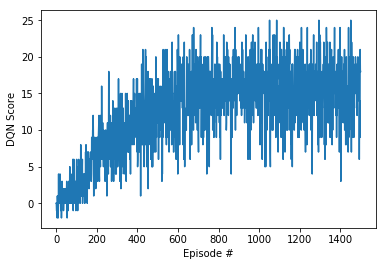

In [7]:
tic = time.perf_counter()
dqn_scores = rl_training(dqn)
toc = time.perf_counter()
print(f"Total training time: {toc - tic:0.4f} seconds")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(dqn_scores)), dqn_scores)
plt.ylabel('DQN Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.61
Episode 200	Average Score: 3.84
Episode 300	Average Score: 6.73
Episode 400	Average Score: 10.56
Episode 500	Average Score: 13.97
Episode 600	Average Score: 14.07
Episode 700	Average Score: 15.72

Environment solved in 600 episodes!	Average Score: 15.72
Episode 800	Average Score: 15.66

Environment solved in 700 episodes!	Average Score: 15.66
Episode 900	Average Score: 16.28

Environment solved in 800 episodes!	Average Score: 16.28
Episode 1000	Average Score: 15.15

Environment solved in 900 episodes!	Average Score: 15.15
Episode 1100	Average Score: 15.85

Environment solved in 1000 episodes!	Average Score: 15.85
Episode 1200	Average Score: 15.62

Environment solved in 1100 episodes!	Average Score: 15.62
Episode 1300	Average Score: 16.49

Environment solved in 1200 episodes!	Average Score: 16.49
Episode 1400	Average Score: 16.82

Environment solved in 1300 episodes!	Average Score: 16.82
Episode 1500	Average Score: 15.79

Environment solved in 1400 episod

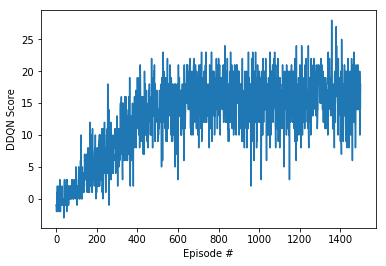

In [8]:
tic = time.perf_counter()
ddqn_scores = rl_training(ddqn)
toc = time.perf_counter()
print(f"Total training time: {toc - tic:0.4f} seconds")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(ddqn_scores)), ddqn_scores)
plt.ylabel('DDQN Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: 0.76
Episode 200	Average Score: 3.97
Episode 300	Average Score: 7.72
Episode 400	Average Score: 10.94
Episode 500	Average Score: 13.01
Episode 600	Average Score: 13.06
Episode 700	Average Score: 14.28
Episode 800	Average Score: 15.60

Environment solved in 700 episodes!	Average Score: 15.60
Episode 900	Average Score: 15.94

Environment solved in 800 episodes!	Average Score: 15.94
Episode 1000	Average Score: 14.91
Episode 1100	Average Score: 16.38

Environment solved in 1000 episodes!	Average Score: 16.38
Episode 1200	Average Score: 16.24

Environment solved in 1100 episodes!	Average Score: 16.24
Episode 1300	Average Score: 15.95

Environment solved in 1200 episodes!	Average Score: 15.95
Episode 1400	Average Score: 15.44

Environment solved in 1300 episodes!	Average Score: 15.44
Episode 1500	Average Score: 16.20

Environment solved in 1400 episodes!	Average Score: 16.20
Total training time: 6663.6201 seconds


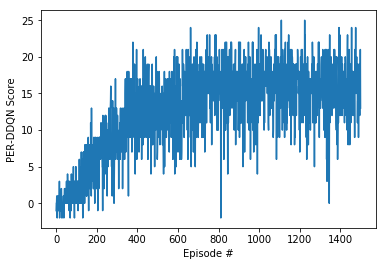

In [9]:
tic = time.perf_counter()
perddqn_scores = rl_training(perddqn)
toc = time.perf_counter()
print(f"Total training time: {toc - tic:0.4f} seconds")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(perddqn_scores)), perddqn_scores)
plt.ylabel('PER-DDQN Score')
plt.xlabel('Episode #')
plt.show()

In [8]:
from dueling_ddqn import Agent as duelingddqn

duelingddqn = duelingddqn(state_size=state_size, action_size=action_size, seed=0)

Episode 100	Average Score: 0.33
Episode 200	Average Score: 3.56
Episode 300	Average Score: 6.52
Episode 400	Average Score: 10.49
Episode 500	Average Score: 12.47
Episode 600	Average Score: 13.87
Episode 700	Average Score: 14.14
Episode 800	Average Score: 14.97
Episode 900	Average Score: 15.73

Environment solved in 800 episodes!	Average Score: 15.73
Episode 1000	Average Score: 16.15

Environment solved in 900 episodes!	Average Score: 16.15
Episode 1100	Average Score: 16.38

Environment solved in 1000 episodes!	Average Score: 16.38
Episode 1200	Average Score: 15.40

Environment solved in 1100 episodes!	Average Score: 15.40
Episode 1300	Average Score: 15.43

Environment solved in 1200 episodes!	Average Score: 15.43
Episode 1400	Average Score: 15.63

Environment solved in 1300 episodes!	Average Score: 15.63
Episode 1500	Average Score: 15.14

Environment solved in 1400 episodes!	Average Score: 15.14
Total training time: 6699.4016 seconds


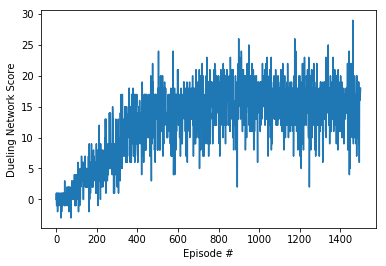

In [9]:
tic = time.perf_counter()
duelingddqn_scores = rl_training(duelingddqn)
toc = time.perf_counter()
print(f"Total training time: {toc - tic:0.4f} seconds")

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(duelingddqn_scores)), duelingddqn_scores)
plt.ylabel('Dueling Network Score')
plt.xlabel('Episode #')
plt.show()

### Results & Discussion

Overview of the scores:

| Agent | Total Training Time | N Episodes to Reach Avg. Score of 13 | Final Avg. Score | Maximum Avg. Score |
|:----|:----:|:----:|:----:|----:|
|DQN | **1235** | 500 | 15.31 | 16.17|
|DDQN | 1298 | **400** | 15.79 | **16.82**|
|PER-DDQN | 6664 | **400** | **16.20** | 16.38|
|Dueling-PER-DDQN | 6699 | 500 | 15.14 | 16.38|

Both Double DQN and Prioritized Experience Replay seem to bring benefits over the vanilla DQN. The picture is less clear about Dueling Networks. 

However, when looking at the graphs of the scores over time, it's clear than all four algorithms' performance has a lot of variance. Some of that variance is probably due to the stockasticity of the game itself, however some might also be due to the algorithms. When considering the variance in performance, the difference in performance between the four algorithms needs to be caveated: we would need to sample a few training trajectories with different seeds for each agent in order to draw firm conclusions about the relative performance of the algorithms.

It's worth noting that the speed at which the agents goes through the episodes is significanlty impacted by prioritized experience replay. It could be improved with more efficient data structures, but the performance hit is likely to remain to some extent because of the additional parameters and need for indexing. At least with the current implementation, it's hard to make a case for using experience replay over the simpler Double DQN. If training time (including time spent tuning hyperparameters) is a factor, it could be better to skip prioritize experience replay.

The performance of the dueling network is a little disappointing. Using the (Wang, 2015) implementation doesn't seem to yield meaningful benefits. In our specific case, the dueling network has more parameters than the other deep Q networks, so it could possibly benefit from training for a longer period of time with more episodes.

### Ideas for future work

Additional improvements to the RL agent can be made, for example:

- [Asynchronous gradient descent, to stabilize the learning algorithm](https://arxiv.org/abs/1602.01783)
- [Learn the distributions of rewards rather than the expectation](https://arxiv.org/abs/1707.06887)
- [Improve exploration with noisy networks](https://arxiv.org/abs/1706.10295)

In addition to this improvements, the performance could likely be improved by tuning the network architecture and the hyperparameters.  